In [85]:
import math
import numpy as np

Problem 6.11

In [13]:
def f_fixed(x: float, c: float) -> float:
    return 1.0 - math.exp(-c * x)

def fprime_fixed(x: float, c: float) -> float:
    return c * math.exp(-c * x)

In [18]:
def step_overrelax(x: float, c: float, omega: float) -> tuple[float, float]:
    fx = f_fixed(x, c)
    x_next = (1.0 + omega) * fx - omega * x

    a = (1.0 + omega) * fprime_fixed(x, c) - omega
    denom = 1.0 - 1.0 / a
    e_est = abs((x - x_next) / denom)
    return x_next, e_est

In [22]:
def solve_fixed_point(c: float,
                      x0: float = 0.5,   
                      omega: float = 0.0,
                      tol: float = 1e-6,
                      maxiter: int = 1_000,
                      verbose: bool = False) -> tuple[float, int, bool]: 

    x = float(x0)
    for it in range(1, maxiter + 1):
        x_next, e_est = step_overrelax(x, c, omega)
        if e_est < tol:
            return x_next, it, True
        x = x_next

    return x, maxiter, False


In [27]:
def run_part_b(c: float = 2.0, tol: float = 1e-6):
    print("\nPart (b): Ordinary relaxation (ω=0) for c=2")
    x, iters, ok = solve_fixed_point(c=c, x0=0.5, omega=0.0, tol=tol)
    print(f"x≈{x:.12f}  iterations={iters}")

def run_part_c(c: float = 2.0, omegas=None, tol: float = 1e-6):
    if omegas is None:
        omegas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
    print("\nPart (c): Overrelaxation omega sweep for c=2")
    results = []
    for w in omegas:
        x, iters, ok = solve_fixed_point(c=c, x0=0.5, omega=w, tol=tol)
        print(f"  ω={w:>4.2f} x≈{x:.12f}  iters={iters}")
        if ok:
            results.append((iters, w, x))
    if results:
        best = min(results)  # fewest iterations
        print(f"\n  Fastest in sweep: ω={best[1]:.2f}  "
              f"({best[0]} iterations),  x≈{best[2]:.12f}")


In [28]:
if __name__ == "__main__":
    run_part_b(c=2.0, tol=1e-6)
    run_part_c(c=2.0, omegas=[0.0, 0.3, 0.5, 0.7, 0.9], tol=1e-6)


Part (b): Ordinary relaxation (ω=0) for c=2
x≈0.796811378194  iterations=15

Part (c): Overrelaxation omega sweep for c=2
  ω=0.00 x≈0.796811378194  iters=15
  ω=0.30 x≈0.796811819805  iters=10
  ω=0.50 x≈0.796811829356  iters=7
  ω=0.70 x≈0.796811929558  iters=4
  ω=0.90 x≈0.796811983650  iters=7

  Fastest in sweep: ω=0.70  (4 iterations),  x≈0.796811929558


Problem 6.13

In [30]:
h  = 6.62607015e-34      
c  = 2.99792458e8        
kB = 1.380649e-23        

In [31]:
def f_eq(x: float) -> float:
    return 5.0*math.exp(-x) + x - 5.0

In [35]:
def bisection(f, a: float, b: float, tol: float = 1e-6, maxiter: int = 10_000):
    fa, fb = f(a), f(b)
    it = 0
    left, right = a, b
    while it < maxiter:
        mid = 0.5*(left + right)
        fm  = f(mid)
        # stop on interval size or tiny residual
        if 0.5*(right - left) < tol or abs(fm) < 1e-14:
            return mid, it+1
        # shrink bracket
        if fa*fm < 0:
            right, fb = mid, fm
        else:
            left, fa = mid, fm
        it += 1
    return mid, it

In [36]:
x_star, iters = bisection(f_eq, a=4.0, b=6.0, tol=1e-6) #choose 4 and 6 since f(4) and f(6) have opposite signs 
b_wien = (h*c) / (kB * x_star)          

print("Root of 5 e^{-x} + x - 5 = 0:")
print(f"  x* ≈ {x_star:.9f}   (iterations: {iters})")

print("\nWien's displacement constant:")
print(f"  b = hc/(k_B x*) ≈ {b_wien:.10e}  m·K")

Root of 5 e^{-x} + x - 5 = 0:
  x* ≈ 4.965113640   (iterations: 21)

Wien's displacement constant:
  b = hc/(k_B x*) ≈ 2.8977723006e-03  m·K


In [37]:
lambda_peak = 502e-9  
T_sun_est = b_wien / lambda_peak
print("\nSolar temperature estimate from λ_max = 502 nm:")
print(f"  T ≈ b / λ_max ≈ {T_sun_est:.2f} K")


Solar temperature estimate from λ_max = 502 nm:
  T ≈ b / λ_max ≈ 5772.45 K


Problem 3

In [86]:
import matplotlib.pyplot as plt

GAMMA_QUAD = 0.20   # step size for the quadratic demo
GAMMA_SMF  = 0.05   # step size for the Schechter chi^2 fit

# Stopping criteria
TOL_STEP = 1e-6     # stop when ||x_{k+1} - x_k|| < TOL_STEP
TOL_GRAD = 1e-8     # or when ||grad|| < TOL_GRAD
MAX_ITERS = 5000


def central_diff_grad(fun, x, rel_step=1e-6, abs_step=1e-8): 
    x = np.asarray(x, dtype=float)
    g = np.zeros_like(x)
    f0 = float(fun(x))
    for i in range(x.size):
        hi = max(abs_step, rel_step * max(1.0, abs(x[i])))
        xp = x.copy(); xp[i] += hi
        xm = x.copy(); xm[i] -= hi
        fp = float(fun(xp))
        fm = float(fun(xm))
        g[i] = (fp - fm) / (2.0 * hi)
    return g, f0


def gradient_descent_fixed(fun, x0, gamma=0.05, tol_step=1e-6, tol_grad=1e-8,
                           max_iter=5000, verbose=False):

    x = np.asarray(x0, dtype=float)
    path = [x.copy()]
    f_hist = []

    g, fval = central_diff_grad(fun, x)
    f_hist.append(fval)
    cur_gamma = float(gamma)

    for k in range(1, max_iter + 1):
        step = -cur_gamma * g
        x_new = x + step
        f_new = float(fun(x_new))

        x, fval = x_new, f_new
        path.append(x.copy())
        f_hist.append(fval)

        # recompute gradient at new point
        g, _ = central_diff_grad(fun, x)

        # stopping
        if np.linalg.norm(step) < tol_step or np.linalg.norm(g) < tol_grad:
            return {"x": x, "f": fval, "path": np.array(path),
                    "f_hist": np.array(f_hist), "iters": k, "converged": True,
                    "message": "converged", "gamma": cur_gamma}

    return {"x": x, "f": fval, "path": np.array(path),
            "f_hist": np.array(f_hist), "iters": max_iter, "converged": False,
            "message": "max_iter reached", "gamma": cur_gamma}



In [87]:
def toy_quadratic(z):
    x, y = z
    return (x - 2.0)**2 + (y - 2.0)**2

def run_quadratic_demo(gamma=GAMMA_QUAD):
    res = gradient_descent_fixed(
        toy_quadratic, x0=np.array([-3.0, 4.0]), #choose random starting point
        gamma=gamma, tol_step=1e-8, tol_grad=1e-10,
        max_iter=2000, verbose=False
    )
    # contour + path
    xs = np.linspace(-4, 4, 300)
    ys = np.linspace(-1, 5, 300)
    X, Y = np.meshgrid(xs, ys)
    F = (X - 2.0)**2 + (Y - 2.0)**2

    plt.figure(figsize=(5.2, 4.6))
    cs = plt.contour(X, Y, F, levels=20)
    plt.clabel(cs, inline=1, fontsize=8, fmt="%.0f")
    P = res["path"]
    plt.plot(P[:, 0], P[:, 1], "o-", lw=1.6, ms=3, label="GD path")
    plt.plot([2.0], [2.0], "r*", ms=12, label="minimum")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(f"GD on $(x-2)^2+(y-2)^2$  (γ={gamma:g})")
    plt.legend(); plt.tight_layout()
    plt.show()
    return res

In [93]:
def load_smf(filename="smf_cosmos.dat"):
    arr = np.loadtxt(filename, usecols=(0, 1, 2))
    logM, n, sn = arr[:, 0], arr[:, 1], arr[:, 2]
    return logM, n, sn

def schechter_perdex(logM, log10_phi, log10_Mstar, alpha):
    M = 10.0 ** logM
    phi = 10.0 ** log10_phi
    Mstar = 10.0 ** log10_Mstar
    t = M / Mstar
    return phi * (t ** (alpha + 1.0)) * np.exp(-t) * np.log(10.0)

def chi2_for_params(theta, logM, n, sn):
    log10_phi, log10_Mstar, alpha = theta
    n_model = schechter_perdex(logM, log10_phi, log10_Mstar, alpha)
    r = (n_model - n) / sn
    return float(np.sum(r * r))

#tried many different starting points
#defined best run as the run with the smallest chi-squared value to plot (but they all ended up having the same value)
def fit_smf_gd_fixed(logM, n, sn, gamma=GAMMA_SMF, tol_step=TOL_STEP, tol_grad=TOL_GRAD,
                     max_iter=MAX_ITERS, verbose=False):
    starts = [
        (-3.0, 10.8, -1.1),
        (-3.5, 11.0, -0.8),
        (-3.2, 10.9, -1.6),
    ]

    best = None
    all_runs = []
    for s in starts:
        fun = lambda th: chi2_for_params(th, logM, n, sn)
        res = gradient_descent_fixed(fun, np.array(s, float),
                                     gamma=gamma, tol_step=tol_step, tol_grad=tol_grad,
                                     max_iter=max_iter, verbose=verbose)
        all_runs.append(res)
        print(f"start {s} -> chi2={res['f']:.3f}  iters={res['iters']}  "
              f"theta={res['x']}  status={res.get('message','')}  γ_final={res.get('gamma',gamma):g}")
        if (best is None) or (res["f"] < best["f"]):
            best = res
    return best, all_runs

In [94]:
def make_fit_plots(logM, n, sn, best_run):
    plt.figure(figsize=(5.4, 3.8))
    it_axis = np.arange(1, len(best_run["f_hist"]) + 1)
    plt.plot(it_axis, best_run["f_hist"], "o-", ms=3)
    plt.xlabel("iteration"); plt.ylabel(r"$\chi^2$")
    plt.title(r"$\chi^2$ vs iteration")
    plt.grid(True, ls=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # best fit line 
    th = best_run["x"]
    log10_phi, log10_Mstar, alpha = th
    logM_fine = np.linspace(np.min(logM) - 0.1, np.max(logM) + 0.1, 600)
    n_fit = schechter_perdex(logM_fine, log10_phi, log10_Mstar, alpha)

    plt.figure(figsize=(6.4, 4.8))
    plt.errorbar(10**logM, n, yerr=sn, fmt="o", ms=3.5, capsize=2, label="data")
    plt.plot(10**logM_fine, n_fit, "-", lw=2.0, label="best-fit Schechter")
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel(r"$M$"); plt.ylabel(r"$n(M)$ [1/(dex·Vol)]")
    plt.title("SMF: data vs best-fit Schechter")
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

Saved plot: gd_fixed_quadratic.png
start (-3.0, 10.8, -1.1) -> chi2=2.908  iters=411  theta=[-2.56824561 10.97624598 -1.00941979]  status=converged  γ_final=9.76563e-05
start (-3.5, 11.0, -0.8) -> chi2=2.908  iters=437  theta=[-2.56824609 10.97624629 -1.00942027]  status=converged  γ_final=9.76563e-05


/var/folders/hf/mzwybxv54rqfdvn46vtf4l7m0000gn/T/ipykernel_112/2846654038.py:12: RuntimeWarning: overflow encountered in power
  return phi * (t ** (alpha + 1.0)) * np.exp(-t) * np.log(10.0)
/var/folders/hf/mzwybxv54rqfdvn46vtf4l7m0000gn/T/ipykernel_112/2846654038.py:12: RuntimeWarning: overflow encountered in multiply
  return phi * (t ** (alpha + 1.0)) * np.exp(-t) * np.log(10.0)


start (-3.2, 10.9, -1.6) -> chi2=2.908  iters=477  theta=[-2.56824583 10.97624612 -1.00942001]  status=converged  γ_final=9.76563e-05

Best-fit parameters:
  log10(phi*) = -2.5682  ->  phi* = 2.7024e-03 [1/(dex·Vol)]
  log10(M*)   = 10.9762  ->  M*  = 9.4677e+10
  alpha       = -1.0094
  chi2        = 2.908  (iters=411, γ_final=9.76563e-05)


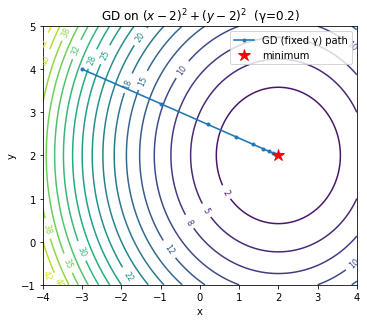

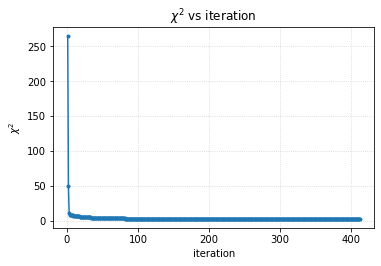

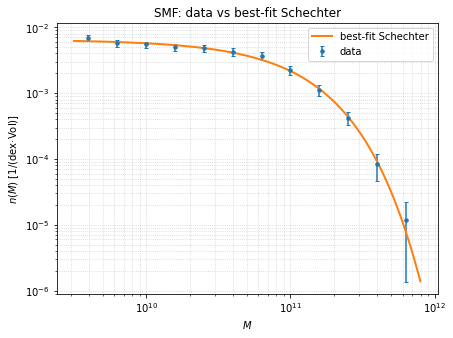

In [95]:
def main():
    demo = run_quadratic_demo(gamma=GAMMA_QUAD)

    logM, n, sn = load_smf("smf_cosmos.dat")

    best, runs = fit_smf_gd_fixed(logM, n, sn, gamma=GAMMA_SMF,
                                  tol_step=TOL_STEP, tol_grad=TOL_GRAD,
                                  max_iter=MAX_ITERS, verbose=False)

    log10_phi, log10_Mstar, alpha = best["x"]
    phi = 10**log10_phi
    Mstar = 10**log10_Mstar
    print("\nBest-fit parameters:")
    print(f"  log10(phi*) = {log10_phi:.4f}  ->  phi* = {phi:.4e} [1/(dex·Vol)]")
    print(f"  log10(M*)   = {log10_Mstar:.4f}  ->  M*  = {Mstar:.4e}")
    print(f"  alpha       = {alpha:.4f}")
    print(f"  chi2        = {best['f']:.3f}  (iters={best['iters']}, γ_final={best.get('gamma',GAMMA_SMF):g})")

    make_fit_plots(logM, n, sn, best)

if __name__ == "__main__":
    main()
